<p style="text-align:center">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="300" alt="Skills Network Logo">
</p>

# Final Project: Building a Rainfall Prediction Classifier
Course clompletion requirement

## Objectives

After completing this lab you will be able to:

* Explore and perform feature engineering on a real-world data set
* Build a classifier pipeline and optimize it using grid search cross validation
* Evaluate your model by interpreting various performance metrics and visualizations
* Implement a different classifier by updating your pipeline
* Use an appropriate set of parameters to search over in each case

## Author

<a href="https://www.linkedin.com/in/pedro-henrique-amorim-de-azevedo-07507b179/" target="_blank">Pedro Henrique Amorim de Azevedo</a>

The dataset you'll use in this project can be downloaded from Kaggle at [https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package/](https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package?resource=download&select=weatherAUS.csv)  
Column definitions were gathered from [http://www.bom.gov.au/climate/dwo/IDCJDW0000.shtml](http://www.bom.gov.au/climate/dwo/IDCJDW0000.shtml?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01)  

The dataset contains observations of weather metrics for each day from 2008 to 2017, and includes the following fields:

| Field         | Description                                           | Unit            | Type   |
| :------------ | :---------------------------------------------------- | :-------------- | :----- |
| Date          | Date of the Observation in YYYY-MM-DD                 | Date            | object |
| Location      | Location of the Observation                           | Location        | object |
| MinTemp       | Minimum temperature                                   | Celsius         | float  |
| MaxTemp       | Maximum temperature                                   | Celsius         | float  |
| Rainfall      | Amount of rainfall                                    | Millimeters     | float  |
| Evaporation   | Amount of evaporation                                 | Millimeters     | float  |
| Sunshine      | Amount of bright sunshine                             | hours           | float  |
| WindGustDir   | Direction of the strongest gust                       | Compass Points  | object |
| WindGustSpeed | Speed of the strongest gust                           | Kilometers/Hour | object |
| WindDir9am    | Wind direction averaged over 10 minutes prior to 9am  | Compass Points  | object |
| WindDir3pm    | Wind direction averaged over 10 minutes prior to 3pm  | Compass Points  | object |
| WindSpeed9am  | Wind speed averaged over 10 minutes prior to 9am      | Kilometers/Hour | float  |
| WindSpeed3pm  | Wind speed averaged over 10 minutes prior to 3pm      | Kilometers/Hour | float  |
| Humidity9am   | Humidity at 9am                                       | Percent         | float  |
| Humidity3pm   | Humidity at 3pm                                       | Percent         | float  |
| Pressure9am   | Atmospheric pressure reduced to mean sea level at 9am | Hectopascal     | float  |
| Pressure3pm   | Atmospheric pressure reduced to mean sea level at 3pm | Hectopascal     | float  |
| Cloud9am      | Fraction of the sky obscured by cloud at 9am          | Eights          | float  |
| Cloud3pm      | Fraction of the sky obscured by cloud at 3pm          | Eights          | float  |
| Temp9am       | Temperature at 9am                                    | Celsius         | float  |
| Temp3pm       | Temperature at 3pm                                    | Celsius         | float  |
| RainToday     | If there was at least 1mm of rain today               | Yes/No          | object |
| RainTomorrow  | If there is at least 1mm of rain tomorrow             | Yes/No          | object |

## Install and import the required libraries

In [ ]:
!pip install -q numpy 
!pip install -q pandas
!pip install -q matplotlib
!pip install -q scikit-learn==1.5.0
!pip install -q seaborn
!pip install -q xgboost
# !pip install -q umap-learn

In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
#from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
from xgboost import XGBClassifier
# from umap import UMAP

## Load the data

In [3]:
url="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/_0eYOqji3unP1tDNKWZMjg/weatherAUS-2.csv"
df = pd.read_csv(url)
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


# Perform EDA on data
Exploratory Data Analysis

In [4]:
# Get number of entries for each column
df.count()

Date             145460
Location         145460
MinTemp          143975
MaxTemp          144199
Rainfall         142199
Evaporation       82670
Sunshine          75625
WindGustDir      135134
WindGustSpeed    135197
WindDir9am       134894
WindDir3pm       141232
WindSpeed9am     143693
WindSpeed3pm     142398
Humidity9am      142806
Humidity3pm      140953
Pressure9am      130395
Pressure3pm      130432
Cloud9am          89572
Cloud3pm          86102
Temp9am          143693
Temp3pm          141851
RainToday        142199
RainTomorrow     142193
dtype: int64

In [5]:
# Get missing values count
df.isna().sum()

Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64

In [6]:
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000


In [7]:
df = df.dropna()
df.isna().sum()

Date             0
Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
dtype: int64

# Consideratons about the dataset

### Data leakage
In this dataset we have columns that contain data from future, which can lead to data leakage. 
This is the case of the 'RainTomorrow' column. To solve this, we can legitimately change the name of rain columns and change our approach to predict today's rainfall with all available data.

In [8]:
df = df.rename(
    columns={
        'RainToday': 'RainYesterday',
        'RainTomorrow': 'RainToday'
    }
)

# Data granularity
Weather patterns change a lot, especially in a large location as Autralia. Our model would have a poor predictability and big complexity do to so. To avoid this e keep things simple, we need to reduce our attention to a smaller region.

Let's keep focused on Melbourne and it's airport which is located only 18km from there.

In [9]:
loc_mask = df['Location'].isin(['Melbourne', 'MelbourneAirport', 'Watsonia'])
df = df[loc_mask]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7557 entries, 64191 to 80997
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           7557 non-null   object 
 1   Location       7557 non-null   object 
 2   MinTemp        7557 non-null   float64
 3   MaxTemp        7557 non-null   float64
 4   Rainfall       7557 non-null   float64
 5   Evaporation    7557 non-null   float64
 6   Sunshine       7557 non-null   float64
 7   WindGustDir    7557 non-null   object 
 8   WindGustSpeed  7557 non-null   float64
 9   WindDir9am     7557 non-null   object 
 10  WindDir3pm     7557 non-null   object 
 11  WindSpeed9am   7557 non-null   float64
 12  WindSpeed3pm   7557 non-null   float64
 13  Humidity9am    7557 non-null   float64
 14  Humidity3pm    7557 non-null   float64
 15  Pressure9am    7557 non-null   float64
 16  Pressure3pm    7557 non-null   float64
 17  Cloud9am       7557 non-null   float64
 18  Cloud3pm

# Outliers

Typically, the presence of outliers makes it difficult to fit the ML model to the dataset. Let's plot the numerical columns using box plot and take a look at them.

The function `plot_boxplots` plots every numeric column in the DataFrame.

The function `identify_outliers` returns a list with all detected outliers using the Interquartile Range (IQR) method.

In [69]:
def plot_boxplots(df, exclude_cols=None):
    if exclude_cols is None:
        exclude_cols = []
        
	# Get only numeric columns
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
    numeric_cols = [col for col in numeric_cols if col not in exclude_cols]
    
    # Calculate the number of rows and columns for the subplot
    n_cols = min(3, len(numeric_cols))
    n_rows = (len(numeric_cols) + n_cols - 1) // n_cols
    
    # Create figure and subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 16))
    
    # Plot each boxplot
    for i, col in enumerate(numeric_cols):
        row_idx = i // n_cols
        col_idx = i % n_cols
        
        # Create the boxplot
        sns.boxplot(y=df[col], ax=axes[row_idx, col_idx], color='cornflowerblue')
        axes[row_idx, col_idx].set_title(f'Boxplot of {col}')
        axes[row_idx, col_idx].set_ylabel('Values')
        
        # Add labels for outliers
        outliers = outliers_column(df[col])
        if len(outliers) > 0:
            axes[row_idx, col_idx].text(0.02, 0.95, f'Outliers: {len(outliers)}', 
                                      transform=axes[row_idx, col_idx].transAxes)
    
    # Remove empty subplots
    for i in range(len(numeric_cols), n_rows * n_cols):
        row_idx = i // n_cols
        col_idx = i % n_cols
        fig.delaxes(axes[row_idx, col_idx])
    
    plt.tight_layout()
    plt.show()
    

def outliers_column(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = column[(column < lower_bound) | (column > upper_bound)]
    return outliers.tolist()


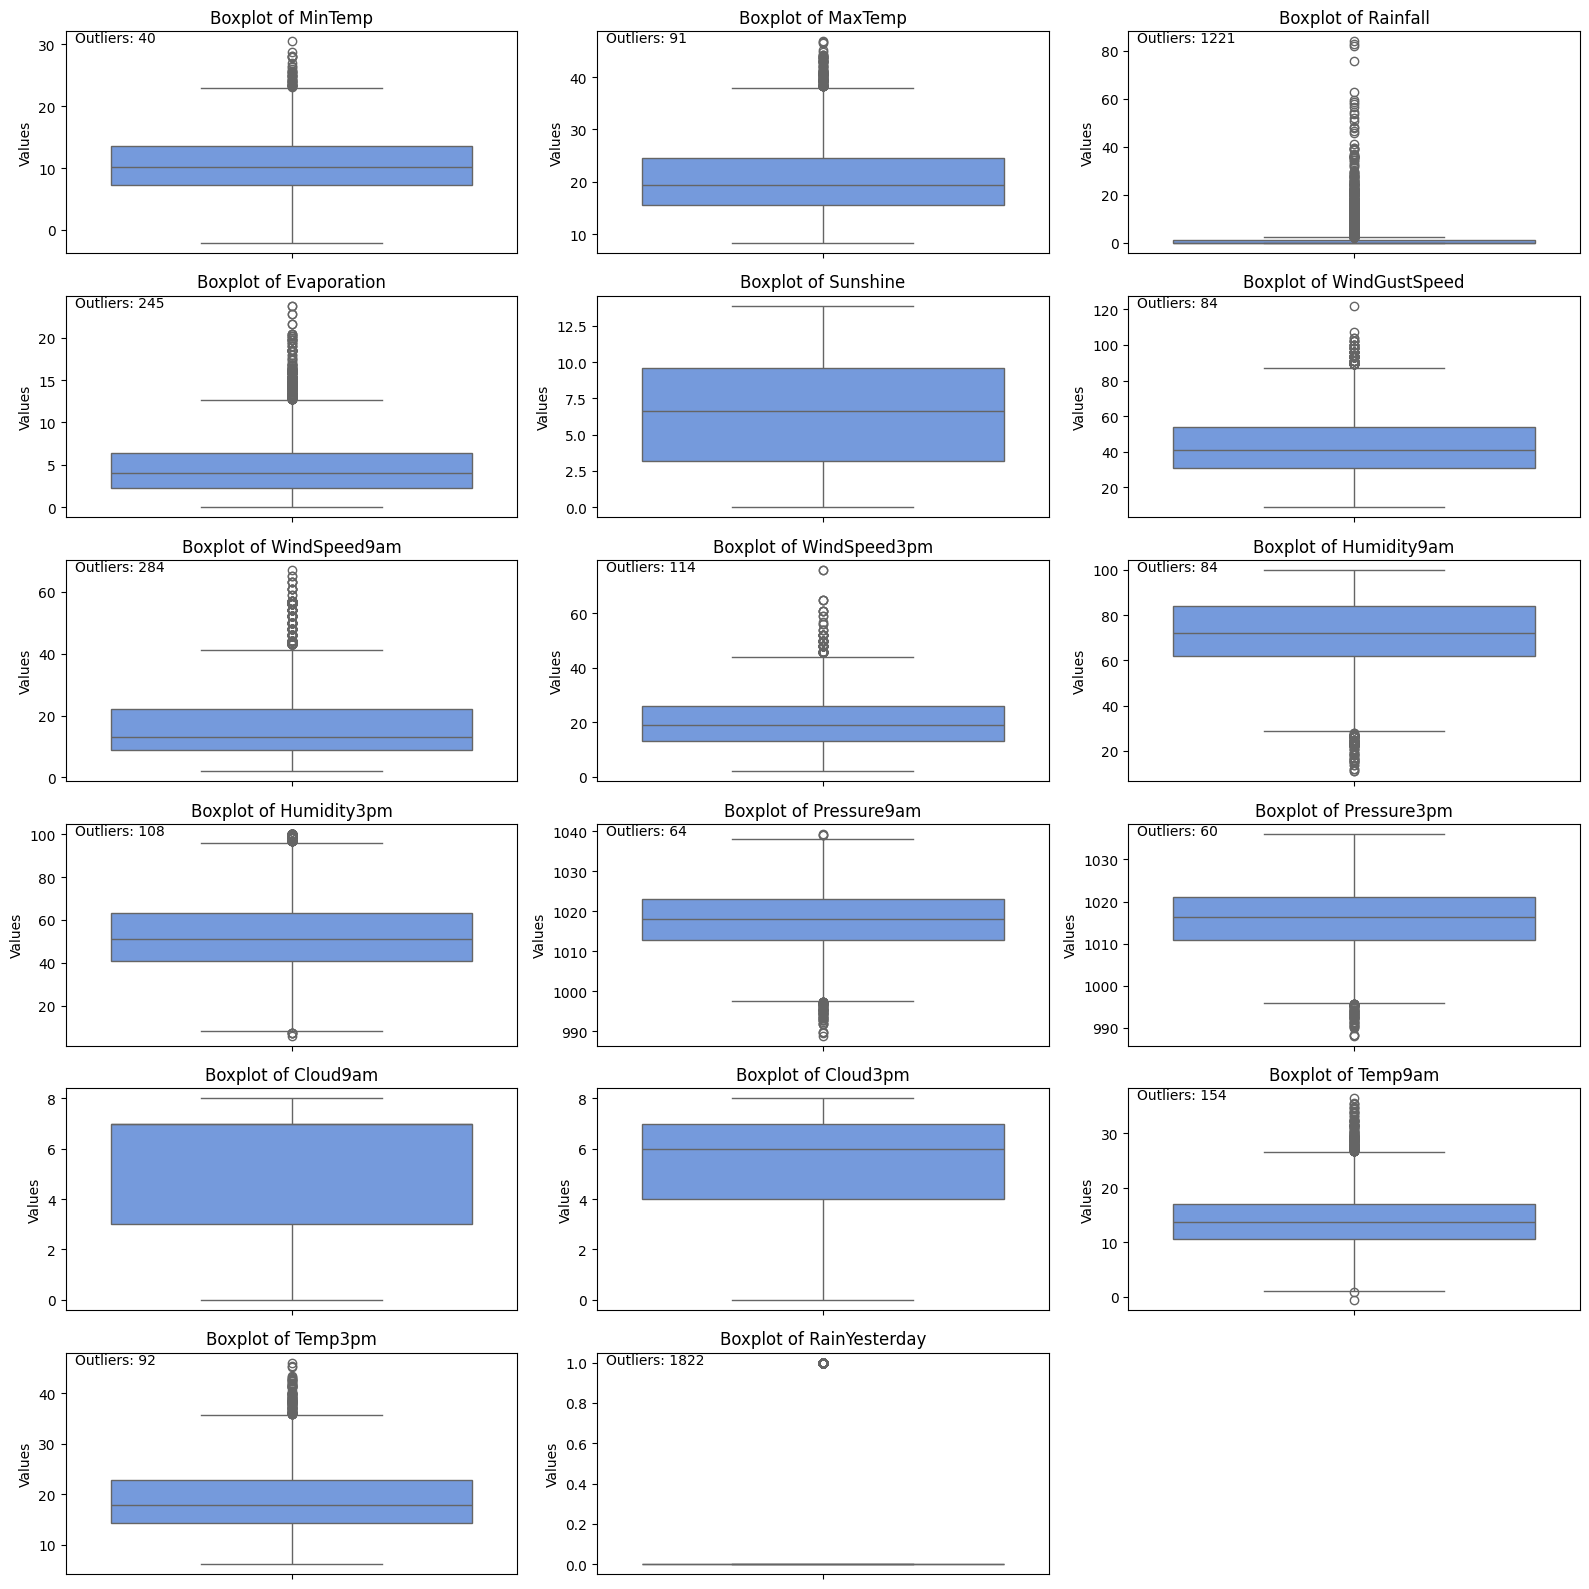

In [70]:
# Plot all coluns except the target one
plot_boxplots(df, exclude_cols=['RainToday'])

## Replacing outliers with Winsorization

As we can see, we have many columns with outliers. In this specific case, we cannot change some columns because even the outliers carry important information. In the case of `Pressure9am` and `Pressure3pm`, we know that extreme changes in atmospheric pressure usually anticipate rain. Same goes for temperatures, humidity and clouds.

During testing, I found that Winsorization is the most effective technique for minimizing the impact of outliers and extreme values without losing the maximum and minimum values, unlike when replacing them with the median. This method works by replacing the smallest and largest values with the nearest non-outlier observations, ensuring that the extremes are preserved, but their influence on the analysis is reduced. The resulting Winsorized mean offers a more robust average that is less affected by outliers, while still retaining the range of the data.

So let's create a function to apply this technique to some columns where we know there may be some outliers due to measurement failures. 

Good candidates are `Rainfall`, `WindGustSpeed`, `Evaporation` and `WindSpeed3pm`. 

In [12]:
def winsorize_outliers(df: pd.DataFrame, cols: list[str]):
	# Create a deep copy of the dataframe to avoid modifying the original
	df_cleaned = df.copy()

	for col_name in cols:
		col_values = df[col_name]

		# Calculate Q1, Q2 and IQR
		q1 = col_values.quantile(0.25)
		q3 = col_values.quantile(0.75)
		iqr = q3 - q1 # Interquartile range

		# Define bounds for outliers
		lower_bound = q1 - (1.5 * iqr)
		upper_bound = q3 + (1.5 * iqr)

		# Values below the lower bound are replaced by the lower bound itself
		df_cleaned.loc[df_cleaned[col_name] < lower_bound, col_name] = lower_bound
        
        # Values above the upper bound are replaced by the upper bound itself
		df_cleaned.loc[df_cleaned[col_name] > upper_bound, col_name] = upper_bound

	return df_cleaned

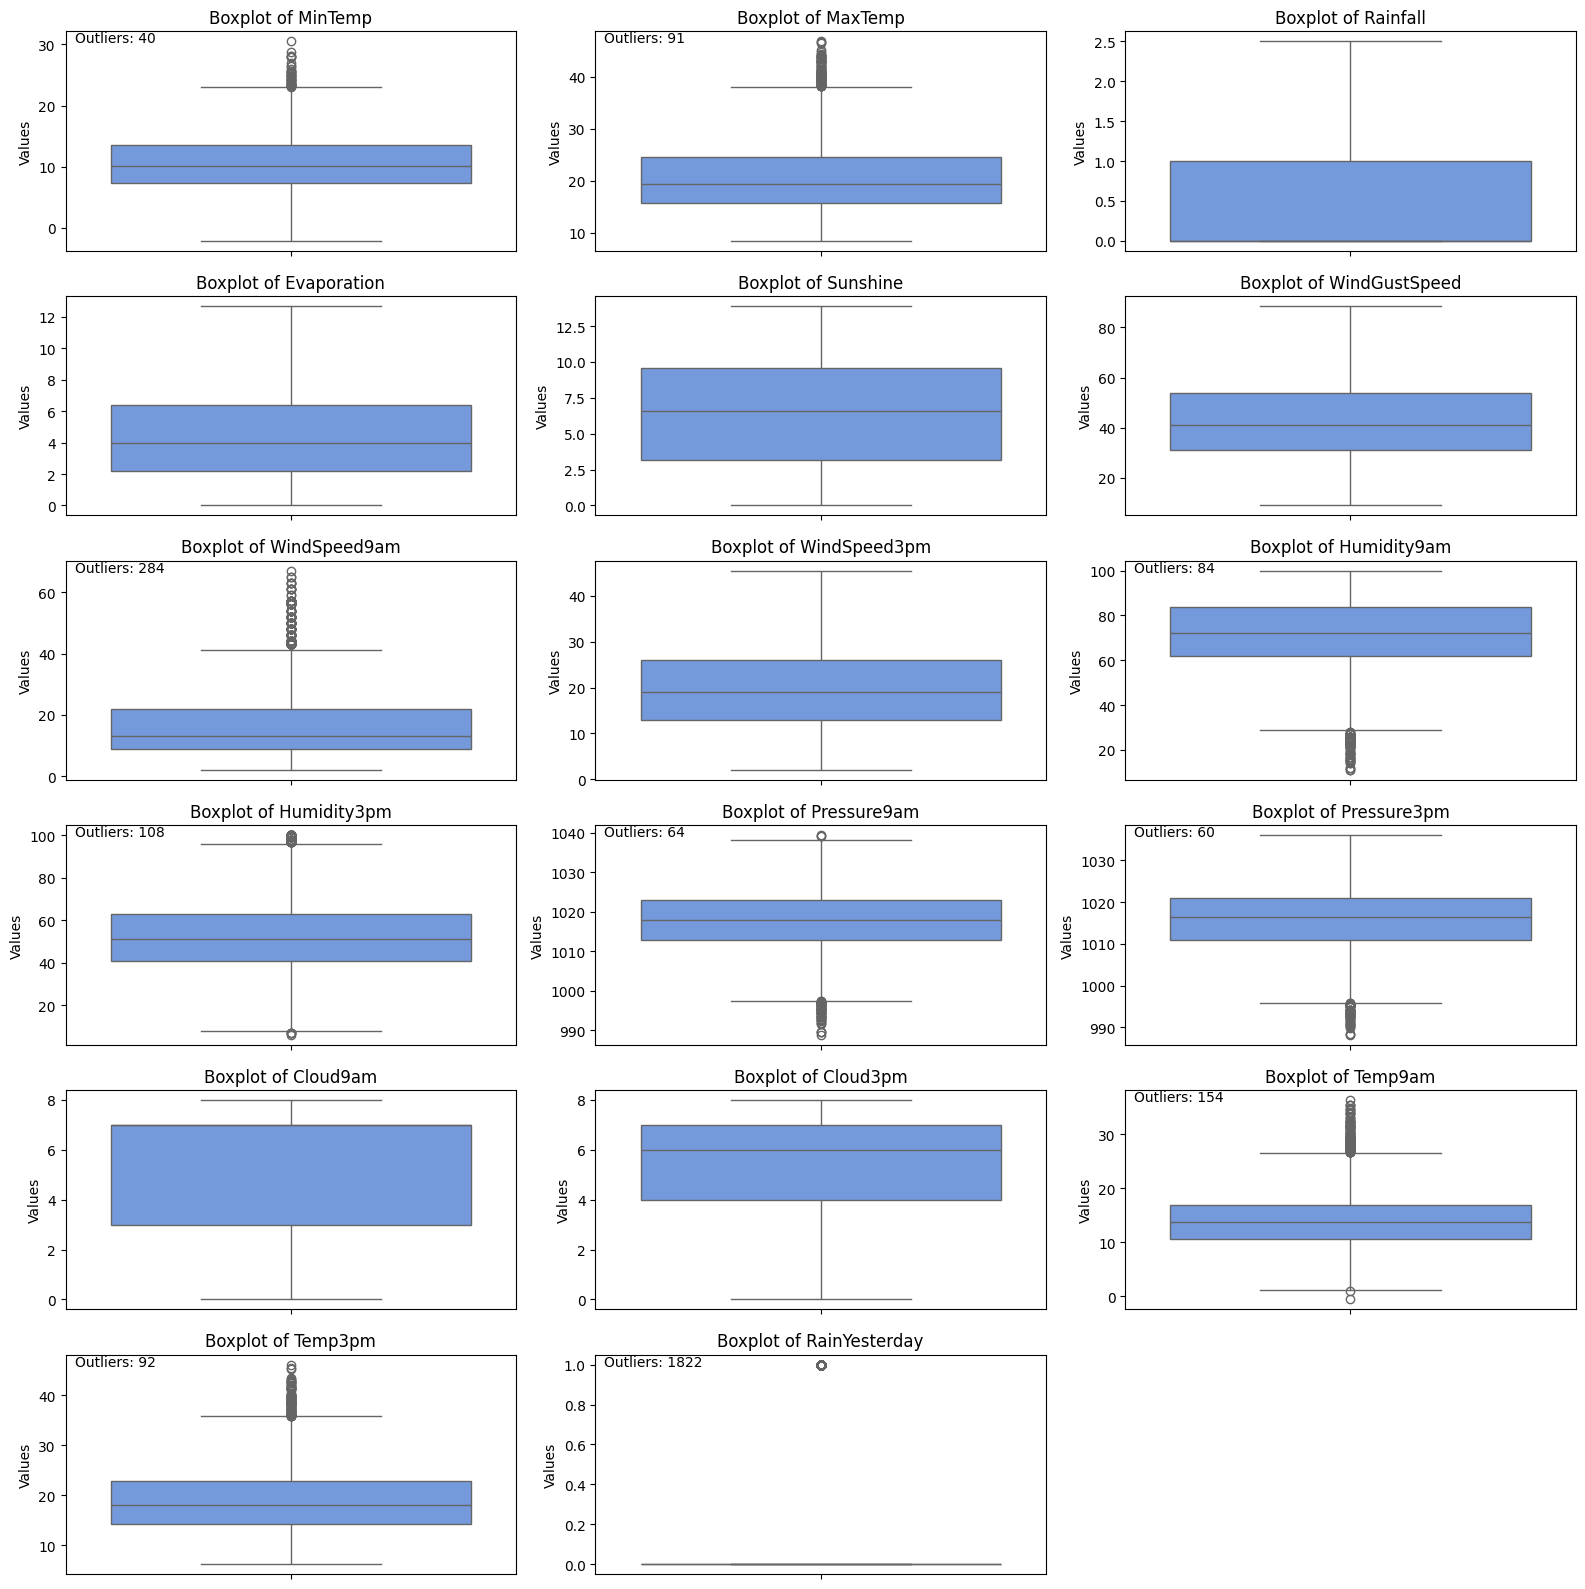

In [71]:
# Get a new dataframe with winzorized values
df = winsorize_outliers(df, cols=['Rainfall', 'WindGustSpeed', 'Evaporation', 'WindSpeed3pm'])

# Let's take a look at the plots
plot_boxplots(df, exclude_cols=['RainToday'])

We can see that we obtained good results with the removal of outliers. Note through the plots that even after the treatment of outliers the distribution of the data remained similar.

# Removing Highly Correlated Columns


In [14]:
def remove_collinear_features(df: pd.DataFrame, columns: list[str], threshold: float):
    # Calculate the correlation matrix
    corr_matrix = df[columns].corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i+1):
            # To get an item via slicing: item = [item_row:item_row+1, item_col:item_col+1]
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            
            col = item.columns # Index object
            row = item.index # Index object
            val = abs(item.values) 

            if val >= threshold:
                # Print the correlated features and the correlation value
                #print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Remove duplicates
    drops = set(drop_cols)
    df = df.drop(columns=drops, axis=1)
    print('Removed Columns {}'.format(drops))
    return df

In [15]:
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
df = remove_collinear_features(df, numeric_cols, 0.80)

# Inspect the dataframe
df.head()

Removed Columns {'Pressure3pm', 'Temp3pm', 'Temp9am'}


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Cloud9am,Cloud3pm,RainYesterday,RainToday
64191,2009-01-01,MelbourneAirport,11.2,19.9,0.0,5.6,8.8,SW,69.0,W,SW,33.0,43.0,55.0,37.0,1005.1,7.0,7.0,No,Yes
64192,2009-01-02,MelbourneAirport,7.8,17.8,1.2,7.2,12.9,SSE,56.0,SW,SSE,31.0,26.0,50.0,43.0,1018.0,6.0,7.0,Yes,No
64193,2009-01-03,MelbourneAirport,6.3,21.1,0.0,6.2,10.5,SSE,31.0,E,S,13.0,19.0,51.0,35.0,1020.8,1.0,7.0,No,No
64194,2009-01-04,MelbourneAirport,8.1,29.2,0.0,6.4,12.5,SSE,35.0,NE,SSE,2.0,20.0,67.0,23.0,1016.2,5.0,4.0,No,No
64195,2009-01-05,MelbourneAirport,9.7,29.0,0.0,7.4,12.3,SE,33.0,SW,SSE,9.0,20.0,51.0,31.0,1011.9,6.0,2.0,No,No


# Creating a seasonality feature

Since weather patterns are seasonal, having different levels of predictability in each season, we can project the Date column into a Season column. In this step, we will transform the Date column into four unique categorical values ​​`Summer`, `Autumn`, `Winter`, `Spring`.

With this categorical approach, our model will fit better to our dataset.

In [16]:
def date_to_season(date):
    month = date.month
    if (month == 12) or (month == 1) or (month == 2):
        return 'Summer'
    elif month >= 3 and month <= 5:
        return 'Autumn'
    elif month >= 6 and month <= 8:
        return 'Winter'
    elif month >= 9 and month <= 11:
        return 'Spring'

In [17]:
df['Date'] = pd.to_datetime(df['Date'])

# Create Season col
df['Season'] = df['Date'].apply(date_to_season)

# Now drop Date col
df = df.drop(columns=['Date'])

df.sample(5)

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Cloud9am,Cloud3pm,RainYesterday,RainToday,Season
78421,Watsonia,15.4,19.7,2.5,3.0,7.3,W,59.0,WNW,W,15.0,33.0,68.0,37.0,1013.6,3.0,5.0,Yes,No,Autumn
78707,Watsonia,8.9,18.2,2.5,3.8,1.5,SW,48.0,WSW,WSW,26.0,15.0,71.0,55.0,1003.7,7.0,7.0,Yes,No,Summer
80619,Watsonia,3.1,14.6,0.4,2.0,4.5,W,19.0,ENE,WSW,6.0,11.0,99.0,50.0,1037.1,7.0,4.0,No,No,Winter
78587,Watsonia,6.3,15.3,0.2,2.0,9.5,N,50.0,N,N,15.0,24.0,69.0,51.0,1020.9,1.0,5.0,No,No,Winter
70331,Melbourne,16.2,17.7,2.5,3.4,3.6,NW,30.0,WNW,S,9.0,6.0,92.0,75.0,1008.1,7.0,7.0,Yes,Yes,Autumn


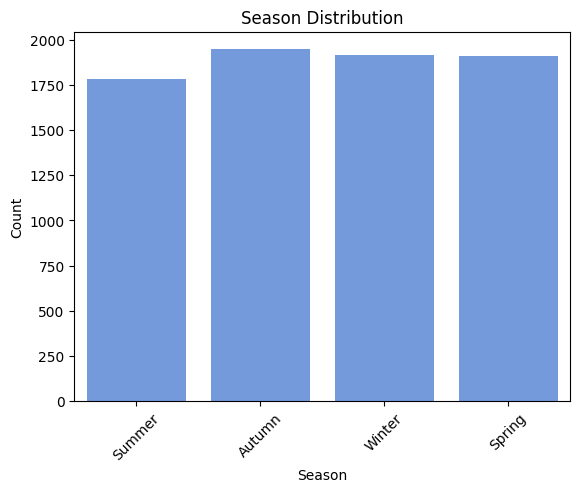

In [66]:
# Let's see how distributed is our new feature across the dataset
sns.countplot(x='Season', data=df, color='cornflowerblue')
plt.xlabel('Season')
plt.ylabel('Count')
plt.title('Season Distribution')
plt.xticks(rotation=45)  # Rotate labels for better readability if needed
plt.show()

As we can see, the new feature is well distributed and can easily be used by our model without further configuration.

# Define feature and target dataframes

For training purposes, let's transform the No e and Yes columns to 0 and 1.

In [19]:
df["RainToday"] = df["RainToday"].map({"No": 0, "Yes": 1})

In [62]:
X = df.drop(columns=['RainToday'], axis=1)
y = df['RainToday']

Let's see how is our target values distributed.

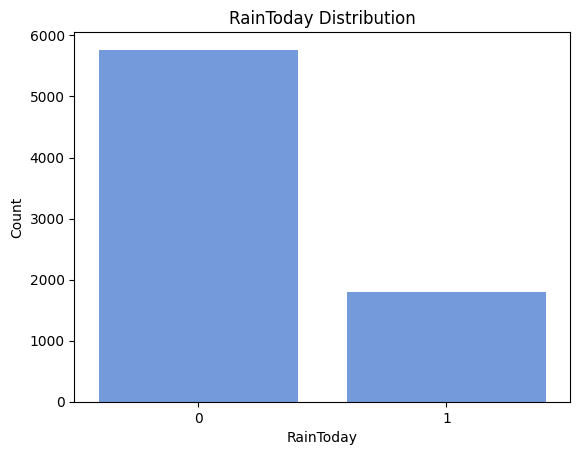

In [65]:
sns.countplot(x='RainToday', data=df, color='cornflowerblue')
plt.xlabel('RainToday')
plt.ylabel('Count')
plt.title('RainToday Distribution')
plt.show()

# Warning!

It's visible that our target variable is poorly balanced, so we must ensure target stratification through some resampling technique such as Synthetic Minority Oversampling Technique (SMOTE). SMOTE is designed to tackle imbalanced datasets by generating synthetic samples for the minority class. 

# Create preprocessing pipeline

By creating a pipeline, we ensure a single and consistent data preprocessing sequence. And this is where we will implement the SMOTE algorithm and UMAP for dimensionality reducion.

First, let's split our data into stratified train and test sets. 

In [22]:
# We must ensure to pass stratify=y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### Creating our data pipeline

Now we must separate numeric and categorical features se we can finally create our pipeline

In [23]:
# Separate data columns
numeric_features = X_train.select_dtypes(include=['number']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Define transformers pipeline for each kind of data
numeric_transformer = Pipeline(steps=[
  	('scaler', StandardScaler()),
  	# ('umap', UMAP(n_components=10, random_state=42)) # Bad results with UMAP
])
categorical_transformer = Pipeline(steps=[
  	('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformers into a single preprocessing ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

classifier = RandomForestClassifier(class_weight='balanced', random_state=42)

# Create a pipeline by combining the preprocessor with a RandomForest model
model_pipeline = Pipeline(steps=[
  	('preprocessor', preprocessor),
  	('SMOTE', SMOTE()),
  	('classifier', classifier) 
])

# Perform grid search
During grid search we repeatedly test diferent model and transformer hyperparameters using cross-validation ensuring we won't touch the test data.

In [ ]:
# Define a param grid to use during cross-validation steps
param_grid = {
	'classifier__n_estimators': [300, 400, 500], # Num of trees
    'classifier__max_depth': [None, 10, 20, 30], # Max depth of each tree
    'classifier__min_samples_split': [2, 5, 10], # Min of samples to split a tree node 
    'classifier__min_samples_leaf': [1, 2, 4], # Min of samples per leaf
    'classifier__bootstrap': [True], # Use bootstrap sampling 
    'classifier__max_features': ['sqrt', 'log2'] # Num of features to be use in each node split
}

# Select cross-validation method
cv = StratifiedKFold(n_splits=5, shuffle=True)

# Instantiate GridSearchCV using our pipeline
grid_search = GridSearchCV(model_pipeline, param_grid, cv=cv, scoring='f1', verbose=2, n_jobs=-1)

grid_search.fit(X_train, y_train)

# Evaluating our model

Now that we finished training our model, let's take a closer look on the metrics.

In [25]:
def print_scores(X_test, y_test, grid_search: GridSearchCV):
	# Get best scoring during cross-validation
	best_cv_score = grid_search.best_score_
	print('Best training score: {:.2f}'.format(best_cv_score))

	# Now get scoring for test data
	test_score = grid_search.score(X_test, y_test)
	print('Test set score: {:.2f}'.format(test_score))

	print('Best parameters: ', grid_search.best_params_)

In [26]:
print_scores(X_test, y_test, grid_search)

Best training score: 0.67
Test set score: 0.65
Best parameters:  {'classifier__bootstrap': True, 'classifier__max_depth': 20, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 300}


As we can see, the score on the test set is quite close to the training score, which is good, but it can still be better.

### Classification Report

The `classification_report` from Scikit-Learn provides key metrics for evaluating a classification model, including precision, recall, F1-score, and support for each class. It helps assess model performance, especially in imbalanced datasets, and is useful for comparing models and tuning hyperparameters.

### Confusion Matrix

The confusion matrix visually represents our model's performance, showing correct and incorrect predictions for each class. It helps identify misclassifications, assess class balance, and guide improvements.

In [131]:
# Function for plotting both confusion matrix and classification report
def plot_conf_matrix_report(X_test, y_test, grid_search: GridSearchCV):
	# Get the best estimator and do predictions on unseen data
	y_pred = grid_search.best_estimator_.predict(X_test)

	clf_report = classification_report(y_test, y_pred, labels=['0', '1'], output_dict=True)
	report_df = pd.DataFrame(clf_report).iloc[:-1, :].T # .iloc[:-1, :] to exclude support
	sns.heatmap(report_df, annot=True)

	conf_matrix = confusion_matrix(y_test, y_pred)
	disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
	disp.plot(cmap='Blues')
	plt.title('Confusion Matrix')
	plt.show();


def plot_conf_matrix_report_2(y_pred, y_test):
	clf_report = classification_report(y_test, y_pred, labels=['0', '1'], output_dict=True)
	report_df = pd.DataFrame(clf_report).iloc[:-1, :].T # .iloc[:-1, :] to exclude support
	sns.heatmap(report_df, annot=True)

	conf_matrix = confusion_matrix(y_test, y_pred)
	disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
	disp.plot(cmap='Blues')
	plt.title('Confusion Matrix')
	plt.show();


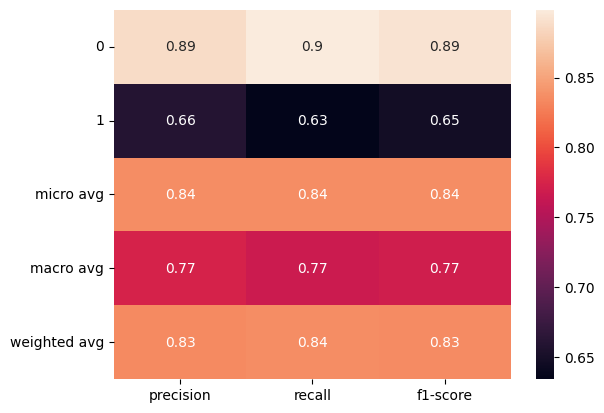

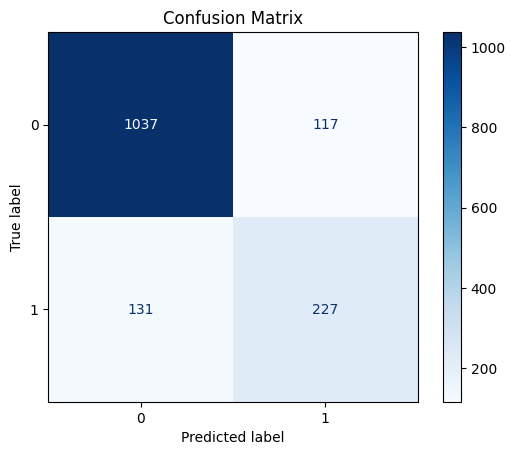

In [28]:
plot_conf_matrix_report(X_test, y_test, grid_search)

### Comparison of Performance Across Different Data Preprocessing Flows

Several training rounds were performed with different forms of data preprocessing. The table below shows the model training metrics for each data preprocessing flow:

| Métrica       | Colinearity Removal ✅  Winsorization ✅  SMOTE ✅ | Colinearity Removal 🚫  Winsorization ✅  SMOTE ✅ | Colinearity Removal ✅  Winsorization 🚫  SMOTE ✅ | Colinearity Removal 🚫  Winsorization 🚫  SMOTE ✅ |
|--------------|---------------------------------|---------------------------------|---------------------------------|---------------------------------|
| **Class 0 - Precision** | 0.89 | 0.89 | 0.88 | 0.89 |
| **Class 0 - Recall**    | 0.90 | 0.90 | 0.91 | 0.91 |
| **Class 0 - F1-score**  | 0.90 | 0.90 | 0.89 | 0.90 |
| **Class 1 - Precision** | 0.67 | 0.67 | 0.67 | 0.69 |
| **Class 1 - Recall**    | 0.63 | 0.63 | 0.60 | 0.66 |
| **Class 1 - F1-score**  | 0.65 | 0.65 | 0.63 | 0.67 |
| **Accuracy**            | 0.84 | 0.84 | 0.84 | 0.85 |
| **Macro Avg - Precision** | 0.78 | 0.78 | 0.78 | 0.79 |
| **Macro Avg - Recall**    | 0.77 | 0.77 | 0.75 | 0.78 |
| **Macro Avg - F1-score**  | 0.77 | 0.77 | 0.76 | 0.79 |
| **Weighted Avg - Precision** | 0.84 | 0.84 | 0.83 | 0.85 |
| **Weighted Avg - Recall**    | 0.84 | 0.84 | 0.84 | 0.85 |
| **Weighted Avg - F1-score**  | 0.84 | 0.84 | 0.83 | 0.85 |

*Results without SMOTE were significantly worse, so they were not included in this table. Results with UMAP were removed as well.*

# Notes

As we can see, our RandomForest model performed better without both collinearity removal and winsorization. So let's re-preprocess our dataset and retrain our model without these steps.

In [29]:
def preprocess_data(df: pd.DataFrame, target_col: str):
    # Remove missing values
    df = df.dropna()

    # Rename columns for clarity
    df = df.rename(columns={'RainToday': 'RainYesterday', 'RainTomorrow': 'RainToday'})

    # Filter for specific locations
    locations = ['Melbourne', 'MelbourneAirport', 'Watsonia']
    df = df[df['Location'].isin(locations)]

    # Convert Date column to datetime format
    df['Date'] = pd.to_datetime(df['Date'])

    # Create a new column for seasons based on the date
    df['Season'] = df['Date'].apply(date_to_season)

    # Drop the Date column as it is no longer needed
    df = df.drop(columns=['Date'])

    # Convert categorical values to numerical format
    df["RainToday"] = df["RainToday"].map({"No": 0, "Yes": 1})
    df["RainYesterday"] = df["RainYesterday"].map({"No": 0, "Yes": 1})

    # Split into features (X) and target variable (y)
    X = df.drop(columns=[target_col])
    y = df[target_col]

    return df, X, y

In [30]:
# Get dataset from url
df = pd.read_csv(url)

# Preprocess data and create feature and target sets
df, X, y = preprocess_data(df, target_col='RainToday')

X.sample(10)

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainYesterday,Season
78415,Watsonia,12.3,29.1,0.0,5.4,10.5,S,26.0,ENE,WSW,...,75.0,38.0,1020.0,1015.6,7.0,1.0,16.1,27.3,0,Autumn
80069,Watsonia,10.5,21.4,0.0,5.4,0.4,SSW,28.0,NE,SSW,...,90.0,69.0,1012.5,1011.0,7.0,7.0,14.5,20.0,0,Summer
79389,Watsonia,13.1,26.6,0.0,7.0,13.0,SSW,41.0,W,SSW,...,66.0,45.0,1013.7,1011.8,3.0,7.0,18.1,24.6,0,Summer
69281,Melbourne,9.7,19.0,0.4,0.8,5.6,NNE,31.0,N,NNE,...,90.0,51.0,1031.4,1027.7,7.0,7.0,10.2,18.3,0,Winter
65827,MelbourneAirport,10.7,21.4,1.8,4.4,8.9,N,56.0,N,N,...,74.0,45.0,1012.2,1009.5,7.0,2.0,13.2,20.5,1,Spring
67188,MelbourneAirport,2.1,16.1,0.2,0.4,7.8,N,39.0,SW,NNW,...,93.0,62.0,1030.3,1027.6,1.0,5.0,6.5,14.8,0,Winter
80341,Watsonia,7.8,13.1,2.8,2.6,4.2,WSW,37.0,SSW,SW,...,98.0,61.0,1020.5,1021.1,7.0,6.0,9.2,12.0,1,Spring
67871,Melbourne,9.2,23.0,0.0,1.6,8.3,N,70.0,N,N,...,78.0,38.0,1025.4,1019.1,7.0,4.0,11.6,22.2,0,Autumn
66823,MelbourneAirport,6.8,14.5,0.0,2.4,9.2,N,61.0,N,NNE,...,72.0,61.0,1034.7,1033.5,7.0,6.0,9.1,13.9,0,Winter
66113,MelbourneAirport,7.5,14.5,0.0,1.6,1.5,W,54.0,NNW,W,...,77.0,63.0,1013.2,1012.5,7.0,7.0,9.7,13.7,0,Winter


In [ ]:
# Split train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Get column names
numeric_features = X_train.select_dtypes(include=['number']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Update our pipeline
model_pipeline.set_params(preprocessor=preprocessor)

# Retrain only with the top features
grid_search.fit(X_train, y_train)

### Metrics for best preprocessing

In [32]:
print_scores(X_test, y_test, grid_search)

Best training score: 0.67
Test set score: 0.67
Best parameters:  {'classifier__bootstrap': True, 'classifier__max_depth': 20, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 300}


### Classification Report and Confusion Matrix

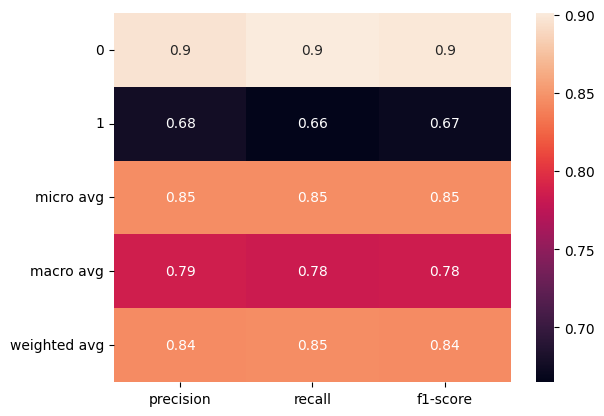

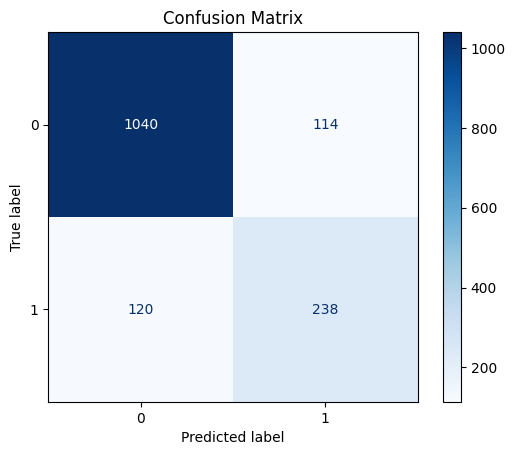

In [33]:
plot_conf_matrix_report(X_test, y_test, grid_search)

# Extracting feature importances

Feature selection is an essential step in machine learning to improve model performance and reduce overfitting. One effective method is selecting features based on their importance scores from a trained model.

In [34]:
def get_feature_importances(grid_search: GridSearchCV):
	# Associate feature importances with their original input variables
	cat_features_backward = list(
		grid_search.best_estimator_['preprocessor']
		.named_transformers_['cat']
		.named_steps['onehot']
		.get_feature_names_out(categorical_features)
	)

	num_features_backward = list(
		grid_search.best_estimator_['preprocessor']
		.named_transformers_['num']
		.get_feature_names_out()
	)

	# Combine numeric and categorical feature names
	feature_names = num_features_backward + cat_features_backward

	feature_importances = grid_search.best_estimator_['classifier'].feature_importances_
	importance_df = pd.DataFrame({
		'Feature': feature_names,
		'Importance': feature_importances
	})
	
	importance_df['Feature'] = importance_df['Feature'].str.split('_').str[0]
	importance_df = importance_df.groupby('Feature', as_index=False).sum()
	importance_df = importance_df.sort_values(by='Importance', ascending=False)

	return importance_df


def plot_feature_importances(features, importances, title='Features importances'):
	# Plot importances
	plt.figure(figsize=(10, 6))
	plt.barh(features, importances, color='cornflowerblue')
	plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
	plt.title(title)
	plt.xlabel('Importance Score')
	plt.show();


### Plot all feature importances

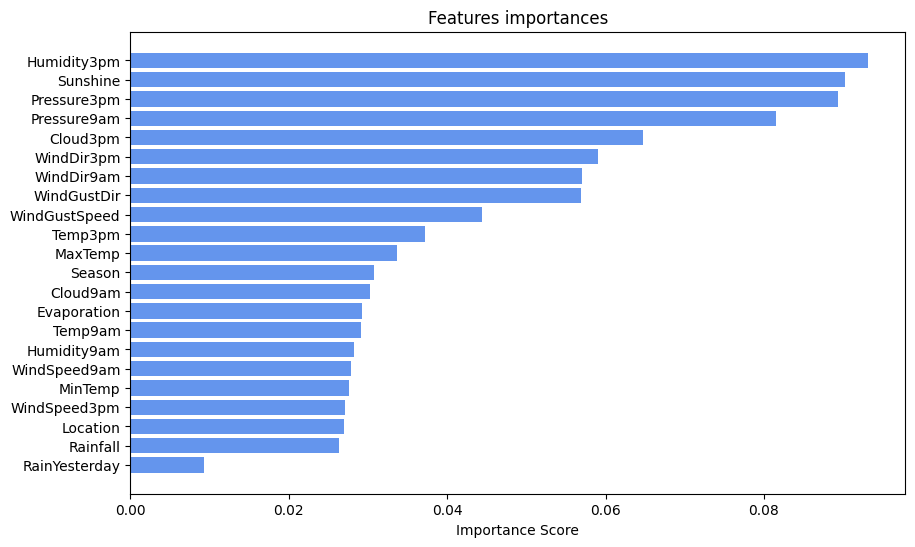

In [35]:
importance_df = get_feature_importances(grid_search)
plot_feature_importances(importance_df['Feature'], importance_df['Importance'])

# Selecting top features

Podemos fazer um cutoff visual ou usar um thresh hold

This approach helps reduce overfitting and improve model performance by keeping only the most relevant features, balancing model complexity and accuracy.

I used a visual cutoff method to select the best features for the model. By plotting feature importance, I identified a threshold above which features were retained. 

# Threshold-Based Selection

Instead of arbitrarily selecting features, we determine a threshold that ensures we retain features contributing significantly to the model’s performance. In this case we set a threshold to retain only the most influential features. Through testing, we identified the optimal `threshold` of 0.85, meaning we keep the most important features until their cumulative importance reaches 85% of the total.

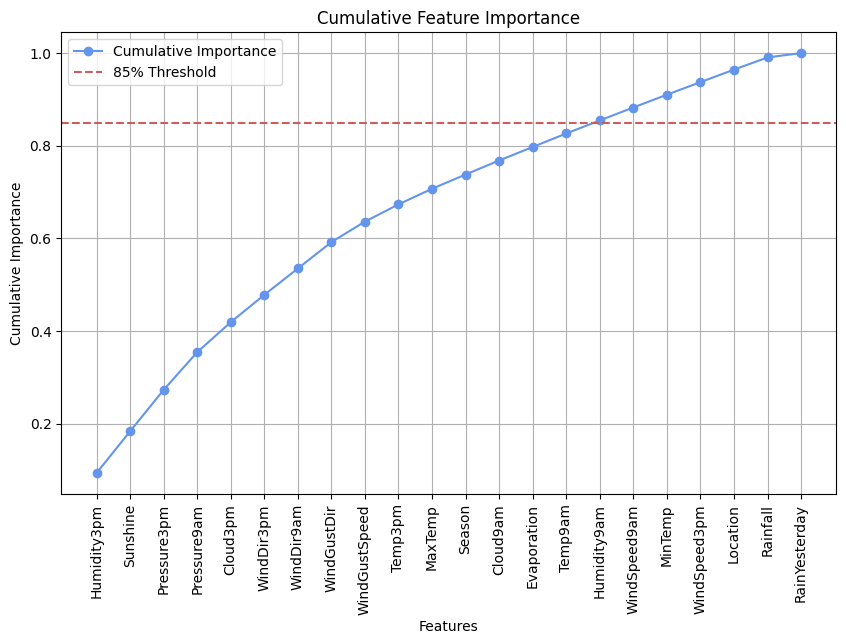

In [135]:
threshold = 0.85 

importance_df["Cumulative Importance"] = np.cumsum(importance_df["Importance"])

plt.figure(figsize=(10, 6))
plt.plot(
	importance_df["Feature"], 
	importance_df["Cumulative Importance"], 
	marker='o', 
	linestyle='-', 
	color='cornflowerblue', 
	label="Cumulative Importance"
)

# Line for threshold
plt.axhline(y=threshold, color='indianred', linestyle='--', label="85% Threshold")
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Cumulative Importance")
plt.title("Cumulative Feature Importance")
plt.legend()
plt.grid()

plt.show()

In [136]:
# Since the 'importance_df_xgb' DataFrame is already sorted by importance,  
# we compute the cumulative sum of feature importance scores.  
cumulative_importance = np.cumsum(importance_df['Importance'])  

# Find the index of the first feature where the cumulative sum exceeds the defined threshold.  
threshold_idx = np.where(cumulative_importance > threshold)[0][0]  

# Select the most important features 
top_features = importance_df[:threshold_idx + 1]  
n_selected_features = len(top_features)  

top_features.head(n_selected_features)  

,Feature,Importance,Cumulative Importance
3,Humidity3pm,0.093188,0.093188
13,Sunshine,0.090171,0.183359
8,Pressure3pm,0.089367,0.272726
9,Pressure9am,0.081501,0.354227
0,Cloud3pm,0.064705,0.418931
16,WindDir3pm,0.058983,0.477914
17,WindDir9am,0.057017,0.534932
18,WindGustDir,0.056869,0.591800
19,WindGustSpeed,0.044336,0.636136
14,Temp3pm,0.037202,0.673338


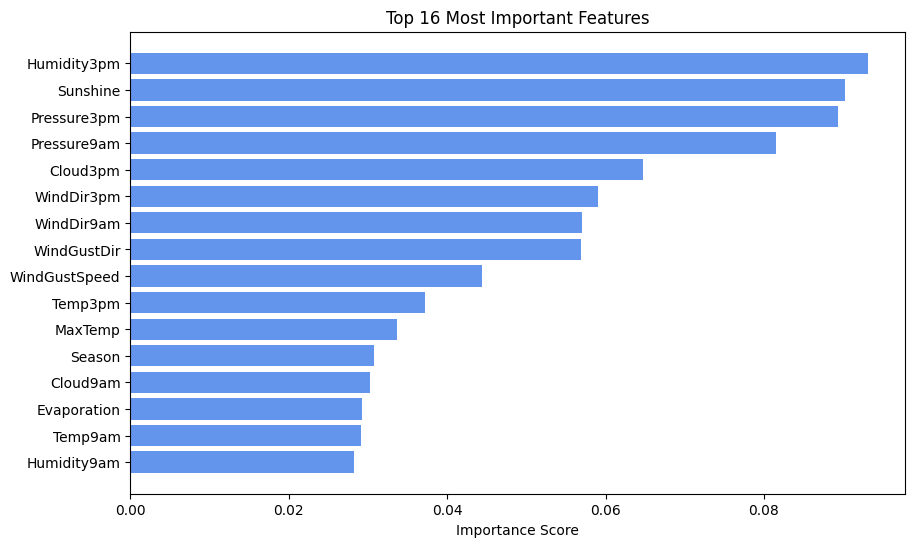

In [137]:
plot_feature_importances(
  	top_features['Feature'], 
  	top_features['Importance'],
    title=f'Top {n_selected_features} Most Important Features'
)

Now that we know which are the best features for our model, let's train another model using them and see if can we improve it even more.

In [138]:
X_tf = df[top_features['Feature']]
y_tf = df['RainToday']

X_tf.head()

,Humidity3pm,Sunshine,Pressure3pm,Pressure9am,Cloud3pm,WindDir3pm,WindDir9am,WindGustDir,WindGustSpeed,Temp3pm,MaxTemp,Season,Cloud9am,Evaporation,Temp9am,Humidity9am
64191,37.0,8.8,1006.4,1005.1,7.0,SW,W,SW,69.0,18.1,19.9,Summer,7.0,5.6,15.9,55.0
64192,43.0,12.9,1019.3,1018.0,7.0,SSE,SW,SSE,56.0,15.8,17.8,Summer,6.0,7.2,12.5,50.0
64193,35.0,10.5,1017.6,1020.8,7.0,S,E,SSE,31.0,19.6,21.1,Summer,1.0,6.2,13.4,51.0
64194,23.0,12.5,1012.8,1016.2,4.0,SSE,NE,SSE,35.0,28.2,29.2,Summer,5.0,6.4,16.0,67.0
64195,31.0,12.3,1010.3,1011.9,2.0,SSE,SW,SE,33.0,27.1,29.0,Summer,6.0,7.4,19.4,51.0


In [ ]:
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(X_tf, y_tf, test_size=0.2, stratify=y, random_state=42)

# Get column names
numeric_features_tf = X_train_tf.select_dtypes(include=['number']).columns.tolist()
categorical_features_tf = X_train_tf.select_dtypes(include=['object', 'category']).columns.tolist()

numeric_transformer_tf = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer_tf = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor_tf = ColumnTransformer(transformers=[
    ('num', numeric_transformer_tf, numeric_features_tf),
    ('cat', categorical_transformer_tf, categorical_features_tf)
])

# Update our pipeline
model_pipeline.set_params(preprocessor=preprocessor_tf)

# Retrain only with the top features
grid_search.fit(X_train_tf, y_train_tf)


Now we evaluate the model trained over the top features.

In [85]:
print_scores(X_test_tf, y_test_tf, grid_search)

Best training score: 0.69
Test set score: 0.68
Best parameters:  {'classifier__bootstrap': True, 'classifier__max_depth': 30, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 500}


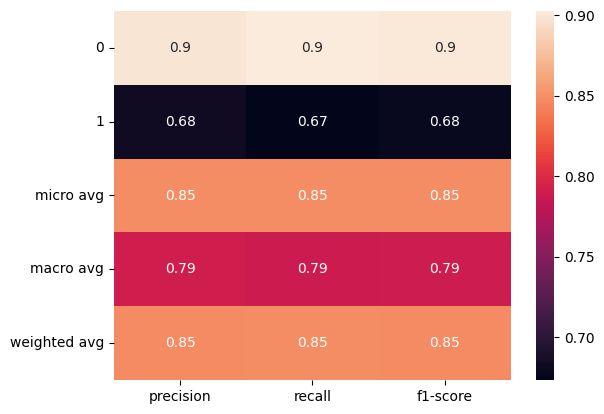

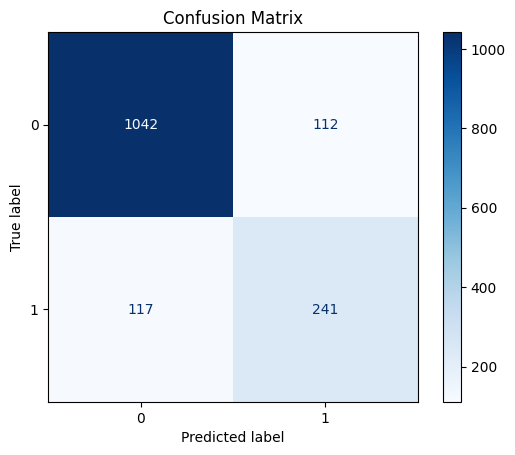

In [86]:
plot_conf_matrix_report(X_test_tf, y_test_tf, grid_search)

As we can see, for the 'Yes' class, threshold-based feature selection is subjective and resulted in only a small improvement.

### Iterative Feature Selection

We'll iteratively train a model using features in descending order of importance from `importance_df`. Starting with the most influential features, we'll add more in each step and evaluate performance.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

results = {}

model_pipeline.set_params(**grid_search.best_params_)

for i in range(3, len(importance_df)): # Start using at least 3 features
	selected_features = importance_df['Feature'][:i]

	X_train_selected = X_train.loc[:, selected_features]
	X_test_selected = X_test.loc[:, selected_features]

	# Each time we try our model with different cols, we need to update the pipeline transformers
	numeric_features = X_train_selected.select_dtypes(include=['number']).columns.tolist()
	categorical_features = X_train_selected.select_dtypes(include=['object', 'category']).columns.tolist()

	numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
	categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

	preprocessor = ColumnTransformer(transformers=[
		('num', numeric_transformer, numeric_features),
		('cat', categorical_transformer, categorical_features)
	])

	# Update our pipeline
	model_pipeline.set_params(preprocessor=preprocessor)

	# We don't need grid search as we already know the best model params
	model_pipeline.fit(X_train_selected, y_train)

	y_pred = model_pipeline.predict(X_test_selected)
	f1 = f1_score(y_test, y_pred) 

	results[i] = f1


best_count_features = max(results, key=results.get)
best_score = results[best_count_features]	

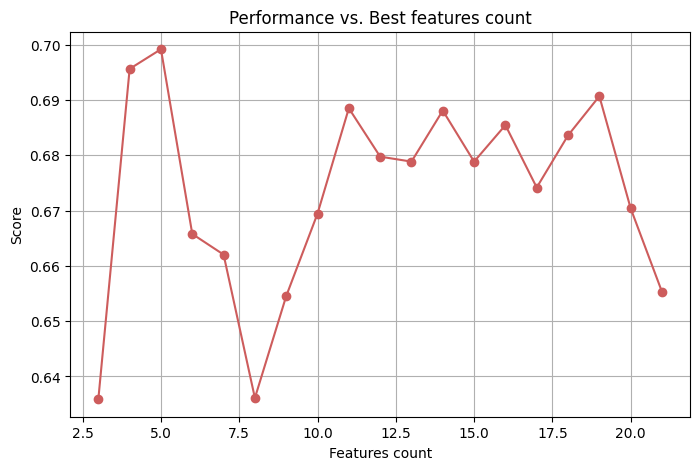

In [130]:
plt.figure(figsize=(8, 5))
plt.plot(results.keys(), results.values(), marker='o', linestyle='-', color='indianred')

plt.xlabel("Features count")
plt.ylabel("Score")
plt.title("Performance vs. Best features count")
plt.grid(True)
plt.show()

The best performance was achieved using 5 features. So, let's train our model using only the top 5 features. 

In [ ]:
top_features = importance_df['Feature'][:5]

# Create the training and test datasets with the top 5 features
X_train_best = X_train.loc[:, top_features]
X_test_best = X_test.loc[:, top_features]

# Update the pipeline transformers
numeric_features = X_train_best.select_dtypes(include=['number']).columns.tolist()
categorical_features = X_train_best.select_dtypes(include=['object', 'category']).columns.tolist()

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Update our model pipeline with the best params and preprocessor
model_pipeline.set_params(**grid_search.best_params_)
model_pipeline.set_params(preprocessor=preprocessor)

model_pipeline.fit(X_train_best, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Humidity3pm', 'Sunshine',
                                                   'Pressure3pm', 'Pressure9am',
                                                   'Cloud3pm']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [])])),
                ('SMOTE', SMOTE()),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=30,
                                        n_estimators=500, random_state=42))])

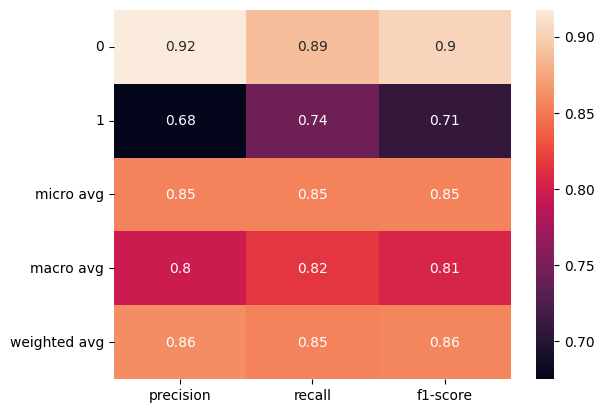

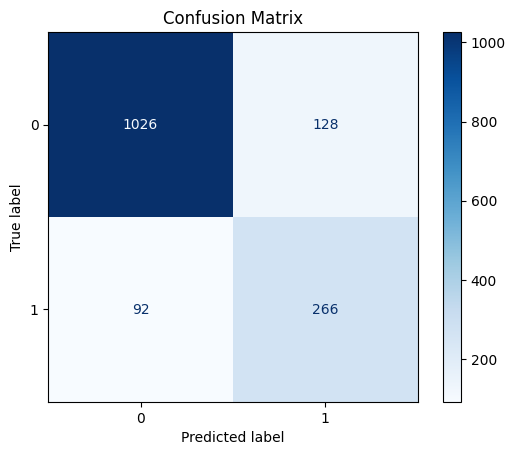

In [ ]:
# Predict and evaluate the model
y_pred = model_pipeline.predict(X_test_best)
plot_conf_matrix_report_2(y_pred, y_test)

# Conclusion About RandomForest

The results are now significantly better than our initial model and there are still many ways to improve the model. However, this process required a lot of time, analysis, and fine-tuning. For larger datasets, repeated training like this would demand substantial computing resources and, consequently, higher costs. As AI Engineers we increase performance but at same time reducing cost much as we can.

Now test a more powerful ways to train a model that requires less fine-tuning and trains much faster to see how well it performs.  

# Using Boosting Techniques

Boosting is an ensemble learning technique where multiple weak learners (usually decision trees) are trained sequentially, with each new model correcting the errors of the previous ones. This approach helps reduce bias and variance, making boosting highly effective for complex and unbalanced datasets.

### XGBoost

XGBoost (Extreme Gradient Boosting) is a better implementation of gradient boosting. It builds trees sequentially to improve performance while offering efficiency and the ability to handle missing values, making it one of the best choices for structured data.

With built-in regularization techniques such as L1 and L2, this model helps prevent overfitting while maintaining good accuracy. Let's train our model and evaluate its performance.

In [139]:
# Get dataset from url
df = pd.read_csv(url)

# Preprocess data and create feature and target sets
df, X, y = preprocess_data(df, target_col='RainToday')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [140]:
# Create feature transformers for XGBoost
numeric_features = X_train.select_dtypes(include=['number']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

xgb_preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

A key advantage of XGBoost is its ability to handle imbalanced datasets using the `scale_pos_weight` parameter. This ensures that the minority class is not overshadowed by the majority class, improving model performance in detecting rare events.

In [141]:
# Create XGBoost Model
ratio = df["RainToday"].value_counts()[0] / df["RainToday"].value_counts()[1]
xgb_model = XGBClassifier(scale_pos_weight=ratio, random_state=42)

xgb_pipeline = Pipeline(steps=[
  	('preprocessor', xgb_preprocessor),
  	('classifier', xgb_model) 
])

In [ ]:
# Create a new grid search for XGBoost
param_grid_xgb = {
  	'classifier__scale_pos_weight': [1, ratio / 2, ratio, ratio * 2, ratio * 5],
    "classifier__n_estimators": [200, 300, 400, 500],
    "classifier__max_depth": [3, 6, 9],
    "classifier__learning_rate": [0.1]
}

cv = StratifiedKFold(n_splits=5, shuffle=True)

# Instantiate GridSearchCV using our pipeline
xgb_grid = GridSearchCV(xgb_pipeline, param_grid_xgb, cv=cv, scoring='f1', verbose=2, n_jobs=-1)

xgb_grid.fit(X_train, y_train)

# XGBoost Evaluation


In [44]:
print_scores(X_test, y_test, xgb_grid)

Best training score: 0.69
Test set score: 0.70
Best parameters:  {'classifier__learning_rate': 0.2, 'classifier__max_depth': 9, 'classifier__n_estimators': 200, 'classifier__scale_pos_weight': 16.09715242881072}


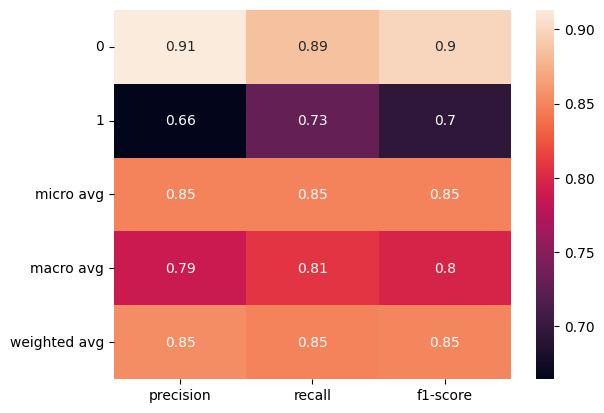

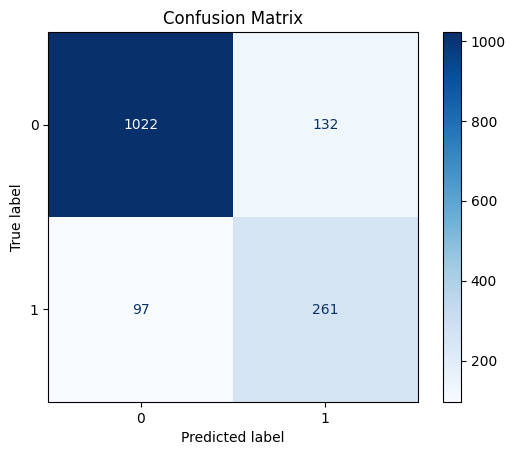

In [45]:
plot_conf_matrix_report(X_test, y_test, xgb_grid)

# Comparing results

As we can see, the XGBoost model achieved almost the same metrics as RandomForest in almost no time and without any fine-tuning such as best feature selection. We also needed much less fits (300 vs 1080) to train the XGBoost. This means that the XGBoost model is great choice to proceed with. 


| Metric       | Random Forest | XGBoost |
|--------------|--------------|---------|
| **Training Time** | 15m 57s | 50.9s |
| **Fits** | 1080 | 300 |
| **Class 0 - Precision** | 0.92 | 0.91 |
| **Class 0 - Recall**    | 0.89 | 0.89 |
| **Class 0 - F1-score**  | 0.90 | 0.90 |
| **Class 1 - Precision** | 0.68 | 0.66 |
| **Class 1 - Recall**    | 0.74 | 0.73 |
| **Class 1 - F1-score**  | 0.71 | 0.70 |
| **Accuracy**            | 0.85 | 0.85 |
| **Macro Avg - Precision** | 0.80 | 0.79 |
| **Macro Avg - Recall**    | 0.82 | 0.81 |
| **Macro Avg - F1-score**  | 0.81 | 0.80 |
| **Weighted Avg - Precision** | 0.86 | 0.85 |
| **Weighted Avg - Recall**    | 0.85 | 0.85 |
| **Weighted Avg - F1-score**  | 0.86 | 0.85 |


_Note that training times may vary accordingly to the machine used to run the project._ 

# Feature importances

Now we need to see which were the best features for ou XGBoost model.

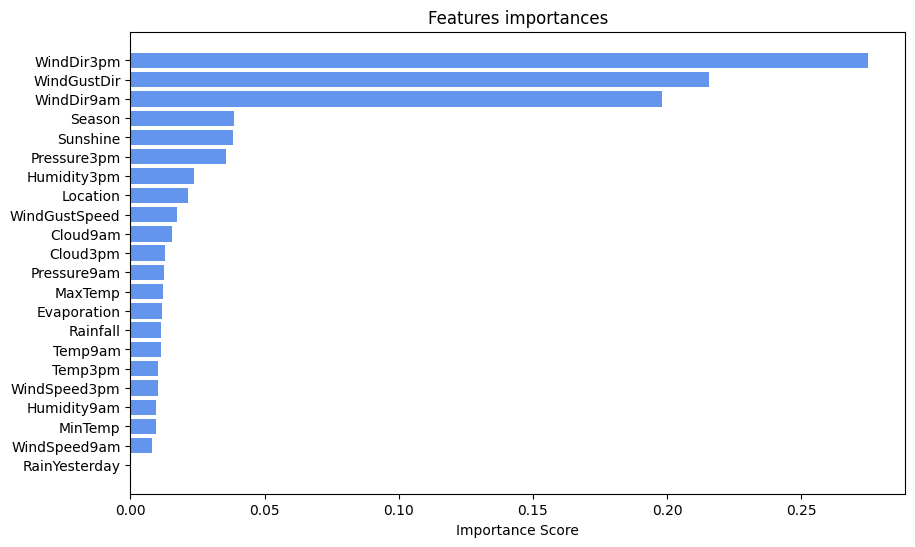

In [46]:
importance_df_xgb = get_feature_importances(xgb_grid)
plot_feature_importances(importance_df_xgb['Feature'], importance_df_xgb['Importance'])

Explicar porque nao selecionamos as melhores features 
Explicar que demorou muito menos e obtivemos quase o mesmo resultado
Conclusão